# OpenAerialMap Segmentation with TorchGeo

This notebook demonstrates how to use the `OpenAerialMap` dataset in TorchGeo to train a semantic segmentation model for building detection.

**Features showcased:**
1. **Catalog Search:** Querying available imagery using the new `search=True` mode.
2. **Data Download:** Downloading specific high-resolution drone imagery.
3. **Intersection Dataset:** combining raster (OAM) and vector (OSM) data.
4. **Training:** Fine-tuning a U-Net model using `RandomGeoSampler`.
5. **Inference:** Visualizing model predictions on real data.

In [46]:
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

from torchgeo.datasets import OpenStreetMap,OpenAerialMap, stack_samples
from torchgeo.samplers import RandomGeoSampler

## 1. Setup Region of Interest

We define a bounding box for **Banepa Municipality, Nepal**. This area has good drone coverage in OpenAerialMap.

In [47]:
WORK_DIR = "data/banepa"
os.makedirs(WORK_DIR, exist_ok=True)

# bbox: [min_lon, min_lat, max_lon, max_lat]
BBOX = [85.514668, 27.628367, 85.528875, 27.638514]

## 2. Browse Available Imagery

We use `search=True` to query the catalog without downloading files. This allows us to inspect metadata and choose the best image.

In [48]:
print("Searching for available images...")
browser = OpenAerialMap(
    paths=WORK_DIR, 
    bbox=BBOX, 
    search=True,  
    max_items=5  )

if browser.search_results is not None:
    display(browser.search_results.head())

Searching for available images...
Found 4 available images

Use .search_results to view.



,ID,Date,Platform,GSD,Title
0,6708341a4a0ab60001b0b94d,2024-10-10,satellite,0.345278,Maxar 105001003E1F0500 Nepal
1,67084ad84a0ab60001b0b95b,2024-10-10,satellite,0.345283,Maxar 1040010095519A00 Nepal
2,62d86c65d8499800053796c4,2022-07-20,uav,0.031627,UAV Images of Banepa Municipality
3,59e62b743d6412ef72209204,,satellite,0.400000,15APR27052125-S3DS_R14C5-054335918020_01_P001.TIF


## 3. Initialize Datasets

We select a specific Image ID from the search results above and download it.
We also download OpenStreetMap building footprints for the same area.

In [49]:
# Selected Image ID (from search results above)
IMAGE_ID = "62d86c65d8499800053796c4"
ZOOM_LEVEL = 18  

print("Initializing OpenAerialMap (Image Layer)...")
oam_dataset = OpenAerialMap(
    paths=os.path.join(WORK_DIR, "oam"),
    bbox=BBOX,
    zoom=ZOOM_LEVEL,
    download=True,
    image_id=IMAGE_ID,
)

Initializing OpenAerialMap (Image Layer)...
Using OpenAerialMap image: UAV Images of Banepa Municipality
  ID: 62d86c65d8499800053796c4
  Platform: uav
  GSD: 0.0316273953754
  License: CC-BY-4.0


  dataset = get_writer_for_path(path, driver=driver)(


In [50]:
print("Initializing OpenStreetMap (Mask Layer)...")
OSM_CLASSES = [{"name": "building", "selector": [{"building": "*"}]}]

osm_dataset = OpenStreetMap(
    paths=os.path.join(WORK_DIR, "osm"),
    bbox=BBOX,
    classes=OSM_CLASSES,
    download=True,
)

Initializing OpenStreetMap (Mask Layer)...


## 4. Intersection Dataset & Sampler

We use the `&` operator to create an IntersectionDataset. This ensures every sample contains both imagery and a corresponding mask.

In [51]:
dataset = oam_dataset & osm_dataset

CHIP_SIZE_PX = 256
chip_size_meters = CHIP_SIZE_PX * oam_dataset.res[0]

sampler = RandomGeoSampler(
    dataset,
    size=chip_size_meters,
    length=50  
)

dataloader = DataLoader(
    dataset,
    sampler=sampler,
    batch_size=8,
    collate_fn=stack_samples
)

print(f"Resolution: {oam_dataset.res[0]:.2f} meters/pixel")
print(f"Chip coverage: {chip_size_meters:.2f} x {chip_size_meters:.2f} meters")
print(f"No of items in dataset : {len(dataset)}")

Converting OpenStreetMap CRS from EPSG:4326 to EPSG:3857
Converting OpenStreetMap res from (0.0001, 0.0001) to (0.5971642834774684, 0.5971642834774684)
Resolution: 0.60 meters/pixel
Chip coverage: 152.87 x 152.87 meters
No of items in dataset : 108


## 5. Model Setup

We use a standard U-Net with a ResNet18 encoder.

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss()

## 6. Training Loop

In [53]:
for epoch in range(20):
    model.train()
    for b in dataloader:
        x, y = b["image"].to(device).float() / 255.0, b["mask"].to(device).long().squeeze(1)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.8210
Epoch 2, Loss: 0.7197
Epoch 3, Loss: 0.6694
Epoch 4, Loss: 0.5886
Epoch 5, Loss: 0.5722
Epoch 6, Loss: 0.5687
Epoch 7, Loss: 0.5237
Epoch 8, Loss: 0.4765
Epoch 9, Loss: 0.3924
Epoch 10, Loss: 0.5138
Epoch 11, Loss: 0.4208
Epoch 12, Loss: 0.3740
Epoch 13, Loss: 0.3190
Epoch 14, Loss: 0.4654
Epoch 15, Loss: 0.3572
Epoch 16, Loss: 0.3469
Epoch 17, Loss: 0.3889
Epoch 18, Loss: 0.3719
Epoch 19, Loss: 0.4003
Epoch 20, Loss: 0.3103


## 7. Visualization

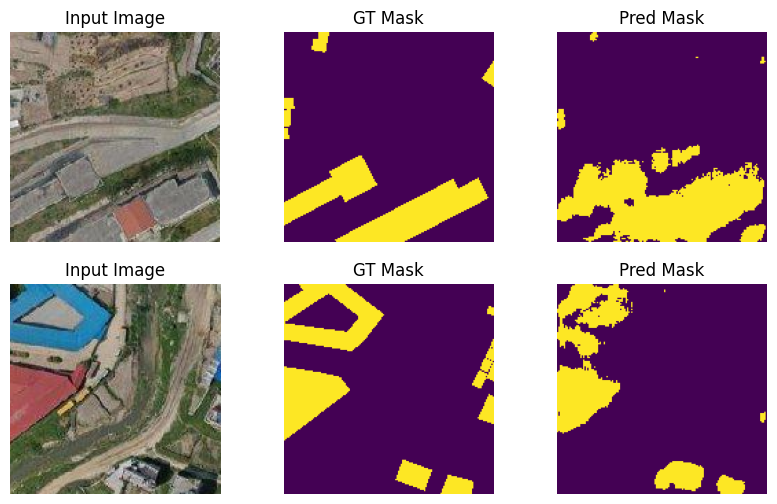

In [54]:
model.eval()
b = next(iter(dataloader))
with torch.no_grad():
    pred = model(b["image"].to(device).float() / 255.0).argmax(1).cpu()

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i in range(2):
    img_display = b["image"][i].permute(1, 2, 0).byte().cpu().numpy()
    ax[i, 0].imshow(img_display)
    ax[i,0].set_title("Input Image")
    ax[i,1].imshow(b["mask"][i].squeeze()); ax[i,1].set_title("GT Mask")
    ax[i,2].imshow(pred[i]); ax[i,2].set_title("Pred Mask")
    [a.axis('off') for a in ax[i]]
plt.show()